In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
from sklearn.model_selection import train_test_split
from datasets.fake_br_corpus import loadTrain

In [25]:
dataset_path = 'datasets/fake_br_corpus/full_texts.csv'

In [26]:
# dataset = pd.read_csv(dataset_path)
dataset = loadTrain(True)

In [27]:
dataset.label.value_counts()

true    3047
fake    3047
Name: label, dtype: int64

In [28]:
for category in dataset.category.unique():
    print('========', category, '========')
    print(dataset[dataset.category == category].label.value_counts())

======== tv_celebridades ========
fake    659
true    653
Name: label, dtype: int64
======== politica ========
fake    1759
true    1754
Name: label, dtype: int64
======== sociedade_cotidiano ========
true    550
fake    541
Name: label, dtype: int64
======== religiao ========
true    22
fake    21
Name: label, dtype: int64
======== ciencia_tecnologia ========
true    49
fake    48
Name: label, dtype: int64
======== economia ========
true    19
fake    19
Name: label, dtype: int64


In [29]:
train, test = train_test_split(dataset, test_size=0.25, stratify=dataset.label)

In [30]:
train.label.value_counts()

true    2285
fake    2285
Name: label, dtype: int64

In [31]:
test.label.value_counts()

true    762
fake    762
Name: label, dtype: int64

In [32]:
dataset.category.value_counts()

politica               3513
tv_celebridades        1312
sociedade_cotidiano    1091
ciencia_tecnologia       97
religiao                 43
economia                 38
Name: category, dtype: int64

# Preprocessing

In [33]:
import spacy
from spacy.lang.pt import STOP_WORDS

In [34]:
nlp = spacy.load('pt')
def lemmatize(text):
    global tokens
    tokens = nlp(text)
    lemmas = [token.lemma_ for token in tokens]
    return ' '.join(lemmas)

def cleanText(text):
    text = re.sub(r'[0-9"\(\)\,\:]+', ' ', text)
    text = re.sub(r'[\n ]+', ' ', text)
    text = text.lower()
    return text

def preprocess(text):
#     text = lemmatize(text)
    text = cleanText(text)
    return text

# Feature extraction

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
tfidf = TfidfVectorizer(
    preprocessor=preprocess,
    ngram_range=(1,3),
    max_features=1000
)

In [37]:
X = tfidf.fit_transform(train.text)

# Classification

In [38]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [39]:
clf1 = SVC()
clf1.fit(X, train.label)

SVC()

In [40]:
clf2 = DecisionTreeClassifier()
clf2.fit(X, train.label)

DecisionTreeClassifier()

In [41]:
X_test = tfidf.transform(test.text)

In [42]:
from sklearn.metrics import classification_report, accuracy_score
def evaluate(clf):
    ypred = clf.predict(X_test)
    ytrue = test.label
    print(classification_report(ytrue, ypred))
    print('accuracy:', accuracy_score(ytrue, ypred))
    return ypred

In [43]:
ypred1 = evaluate(clf1)

              precision    recall  f1-score   support

        fake       0.89      0.90      0.89       762
        true       0.90      0.88      0.89       762

    accuracy                           0.89      1524
   macro avg       0.89      0.89      0.89      1524
weighted avg       0.89      0.89      0.89      1524

accuracy: 0.8930446194225722


In [44]:
ypred2 = evaluate(clf2)

              precision    recall  f1-score   support

        fake       0.75      0.74      0.74       762
        true       0.74      0.75      0.74       762

    accuracy                           0.74      1524
   macro avg       0.74      0.74      0.74      1524
weighted avg       0.74      0.74      0.74      1524

accuracy: 0.7427821522309711


In [45]:
def resultsPerCategory(ypred):
    for category in test.category.unique():
        print('========', category, '========')
        print(classification_report(test.label[test.category == category], ypred[test.category == category]))

In [54]:
resultsPerCategory(ypred2)

======== politica ========
              precision    recall  f1-score   support

        fake       0.75      0.75      0.75       447
        true       0.75      0.75      0.75       445

    accuracy                           0.75       892
   macro avg       0.75      0.75      0.75       892
weighted avg       0.75      0.75      0.75       892

======== tv_celebridades ========
              precision    recall  f1-score   support

        fake       0.76      0.76      0.76       163
        true       0.75      0.74      0.75       156

    accuracy                           0.75       319
   macro avg       0.75      0.75      0.75       319
weighted avg       0.75      0.75      0.75       319

======== sociedade_cotidiano ========
              precision    recall  f1-score   support

        fake       0.76      0.70      0.73       128
        true       0.74      0.79      0.76       136

    accuracy                           0.75       264
   macro avg       0.75      

In [55]:
test.category.value_counts()

politica               892
tv_celebridades        319
sociedade_cotidiano    264
ciencia_tecnologia      24
religiao                14
economia                11
Name: category, dtype: int64

---

In [56]:
testNumWords = test.text.apply(lambda text: len(preprocess(text).split())).values

In [57]:
binYpred = np.where(ypred2 == 'fake', 1, 0)
binYtrue = np.where(test.label == 'fake', 1, 0)

In [58]:
proba2 = clf2.predict_proba(X_test)

In [59]:
df = pd.DataFrame({'pred': binYpred, 'true':binYtrue, 'wordCount':testNumWords})
# df = pd.DataFrame({'pred':ypred2, 'true':test.label, 'wordCount':testNumWords})
df0 = df[df.true == 0]
df1 = df[df.true == 1]

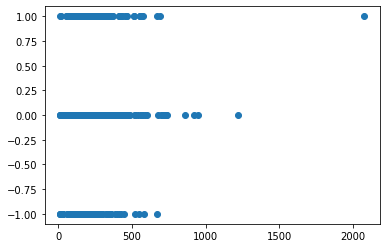

In [60]:
# plt.scatter(testNumWords, proba2.T[0])
# plt.scatter(testNumWords, binYtrue)
plt.scatter(df.wordCount, df.true - df.pred)

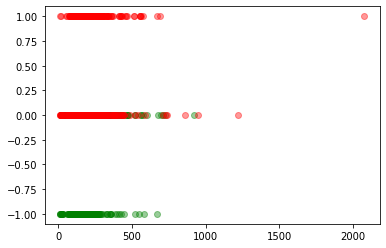

In [61]:
plt.scatter(df0.wordCount, df0.true - df0.pred, alpha=0.4, c='g')
plt.scatter(df1.wordCount, df1.true - df1.pred, alpha=0.4, c='r')

In [62]:
train

,author,average sentence length,average word length,category,date of publication,diversity,emotiveness,filename,id,label,...,number of tokens,number of types,number of verbs,number of words in upper case,number of words without punctuation,pausality,percentage of news with speeling errors,text,words,originalText
2909,"Por Mateus Rodrigues, G1 DF",18.52080,5.11811,politica,04/05/2016 09h37,0.530934,0.218447,2044.txt,3125.0,true,...,1030.0,472.0,163.0,10.0,889.0,2.93750,0.000000,Escola tem que ser tolerante e respeitar diver...,"['Escola', 'tem', 'que', 'ser', 'tolerante', '...",Escola tem que ser tolerante e respeitar diver...
845,Por G1,16.25810,4.72619,tv_celebridades,14/03/2018 15h38,0.523810,0.173709,1814.txt,348.0,true,...,630.0,264.0,54.0,0.0,504.0,4.06452,0.001984,Relatório aponta Finlândia como país mais feli...,"['Relatório', 'aponta', 'Finlândia', 'como', '...",Relatório aponta Finlândia como país mais feli...
816,None,9.66667,4.77011,politica,03/03/2016,0.839080,0.200000,3141.txt,3866.0,fake,...,107.0,73.0,7.0,24.0,87.0,2.22222,0.000000,Plenário hoje  Bolsonaro manda recado para Di...,"['Plenário', 'hoje', '\x96', 'Bolsonaro', 'man...",NaN
4349,"Por Kleber Tomaz, G1 SP, São Paulo",15.24420,4.53699,tv_celebridades,29/03/2018 03h01,0.408848,0.195440,1016.txt,800.0,true,...,1529.0,536.0,269.0,10.0,1311.0,2.53488,0.000000,Avô paterno de Isabella Nardoni diz que chora ...,"['Avô', 'paterno', 'de', 'Isabella', 'Nardoni'...",Avô paterno de Isabella Nardoni diz que chora ...
1991,None,17.95120,4.64538,tv_celebridades,10/5/2017,0.584239,0.216949,361.txt,1821.0,true,...,942.0,430.0,98.0,6.0,736.0,5.02439,0.002717,Nelson Xavier morre aos 75 anos em Uberlândia\...,"['Nelson', 'Xavier', 'morre', 'aos', '75', 'an...",Nelson Xavier morre aos 75 anos em Uberlândia\...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,Renan Truffi,19.70000,5.01777,politica,28/11/2017,0.631980,0.130890,103.txt,2165.0,true,...,468.0,249.0,66.0,15.0,394.0,3.70000,0.000000,Joesley se mantém em silêncio em CPMI\n\nEmpre...,"['Joesley', 'se', 'mantém', 'em', 'silêncio', ...",Joesley se mantém em silêncio em CPMI\n\nEmpre...
5535,José Nêumanne,26.69330,4.74575,tv_celebridades,08 de dezembro de 2017,0.444056,0.187356,2045.txt,2749.0,true,...,2277.0,889.0,278.0,26.0,2002.0,3.66667,0.004496,Ao acusar a Lava Jato de ser a responsável pe...,"['', 'Ao', 'acusar', 'a', 'Lava', 'Jato', 'de'...",Ao acusar a Lava Jato de ser a responsável pe...
4600,None,15.71430,4.98636,sociedade_cotidiano,07/11/2016,0.631818,0.236559,1978.txt,4988.0,fake,...,254.0,139.0,34.0,1.0,220.0,2.42857,0.009091,Qual o problema em quebrar uma estátua em Port...,"['Qual', 'o', 'problema', 'em', 'quebrar', 'um...",NaN
2473,"Fabiana Cambricoli, O Estado de S.Paulo",24.44120,4.90854,sociedade_cotidiano,07 de fevereiro de 2017,0.415162,0.216578,1610.txt,690.0,true,...,918.0,345.0,145.0,2.0,831.0,2.55882,0.002407,Médica demitida do Sírio nega divulgação de da...,"['Médica', 'demitida', 'do', 'Sírio', 'nega', ...",Médica demitida do Sírio nega divulgação de da...
